# Vertical interpolation

This small notebook is meant to show vertical interpolation possibilities with AQUA. The method is included in the `Reader` but it is nothing more than a wrapper of the Xarray built-in `interp()` function. 
Let's see a few example!

## FESOM

Let's open some 3d data, and ask them to regrid so that we can plot them

In [3]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5-cycle3", source="3D_daily_native", regrid="r100")
data = reader.retrieve()
data

2023-11-30 16:35:27 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-30 16:35:27 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-30 16:35:27 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:35:27 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:35:27 :: eccodes :: WARNING  -> ShortName wo have multiple grib codes associated: ['262507', '151133']
2023-11-30 16:35:27 :: eccodes :: WARNING  -> AQUA will take the first so that wo -> 262507, please set up a correct fix if this does not look right
2023-11-30 16:35:27 :: eccodes :: WARNING  -> ShortName so have multiple grib codes associated: ['262500', '151130']
2023-11-30 16:35:27 :: eccodes :: WARNING  -> AQUA will take the first so that so -> 262500, p

<xarray.Dataset>
Dimensions:  (nz: 70, time: 1808, nod2: 7402886, nz1: 69)
Coordinates:
  * nz       (nz) float64 0.0 5.0 10.0 15.0 ... 5.4e+03 5.65e+03 6e+03 6.35e+03
  * time     (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
Dimensions without coordinates: nod2
Data variables:
    vdf      (time, nz, nod2) float32 dask.array<chunksize=(1, 70, 7402886), meta=np.ndarray>
    so       (time, nz1, nod2) float32 dask.array<chunksize=(1, 69, 7402886), meta=np.ndarray>
    ocpt     (time, nz1, nod2) float32 dask.array<chunksize=(1, 69, 7402886), meta=np.ndarray>
    wo       (time, nz, nod2) float32 dask.array<chunksize=(1, 70, 7402886), meta=np.ndarray>
Attributes: (12/18)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       dfbf523
    FESOM_MeshPath:                      /work/bm1235/ifs-inputs_nxg_c3/fesom...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /work/bm1235/ifs-inputs_nxg_c3/fesom...
    ...                                  ...
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    FESOM_autorotate_back_to_geo:        -1
    history:                             2023-11-30 16:35:27 retrieved by AQU...

We exploit 3D regridding and we create a more practical dataset. Please be aware for oceanic dataset that it is mandatory to interpolate on the horizontal grid before interpolating on the vertical axis, while this should not be necessary for atmospheric datasets. This is because weights for regridding are available on the original vertical levels, and in the ocean this will not work if you move to a different vertical level. On the other hand, for the atmosphere weights are not dependent on the vertical level so the operation can be done in any order 

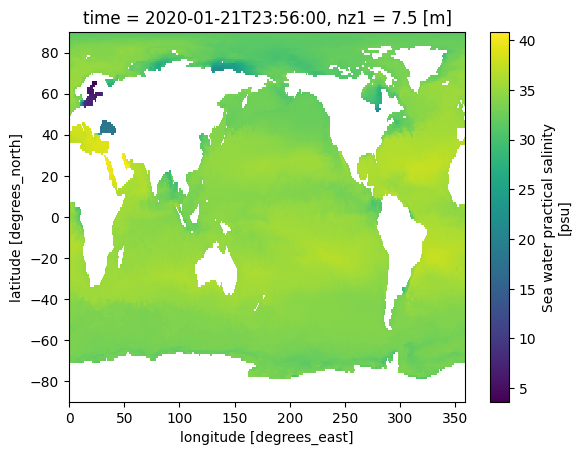

In [4]:
regridded = reader.regrid(data)
regridded['so'][1,1,:,:].plot()

FESOM 3D data has two vertical axes, so that we need to decide on which of them we want to perform the interpolation. Let's do it on `nz1`. We can then simply call the `vertinterp()` method. For convenience we subselect two timesteps. 

In [5]:
vint = reader.vertinterp(regridded.isel(time=[0,1]), levels=[10, 20], vert_coord='nz1')
vint

2023-11-30 16:36:09 :: Reader :: WARNING  -> Units of vert_coord=nz1 has not defined, reading from the data


<xarray.Dataset>
Dimensions:  (time: 2, lat: 180, lon: 360, nz1: 2)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T23:56:00 2020-01-21T23:56:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * nz1      (nz1) int64 10 20
Data variables:
    so       (time, nz1, lat, lon) float64 dask.array<chunksize=(1, 2, 180, 360), meta=np.ndarray>
    ocpt     (time, nz1, lat, lon) float64 dask.array<chunksize=(1, 2, 180, 360), meta=np.ndarray>
Attributes: (12/18)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       dfbf523
    FESOM_MeshPath:                      /work/bm1235/ifs-inputs_nxg_c3/fesom...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /work/bm1235/ifs-inputs_nxg_c3/fesom...
    ...                                  ...
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    FESOM_autorotate_back_to_geo:        -1
    history:                             2023-11-30 16:35:27 retrieved by AQU...

We can then simply plot it.

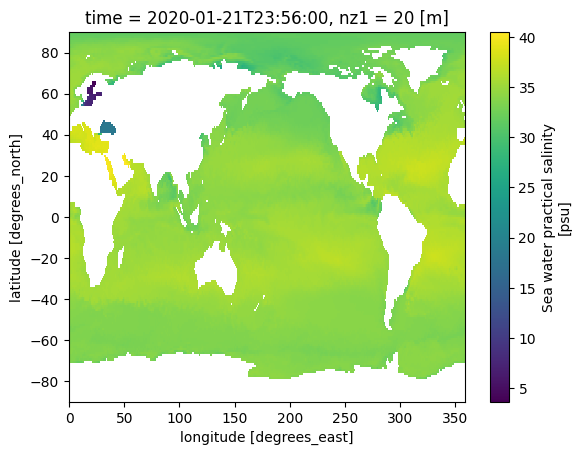

In [6]:
vint['so'][1,1,:,:].plot()

Please note that this is not identical from the previous plot, i.e. the vertical interpolation works as expected. 

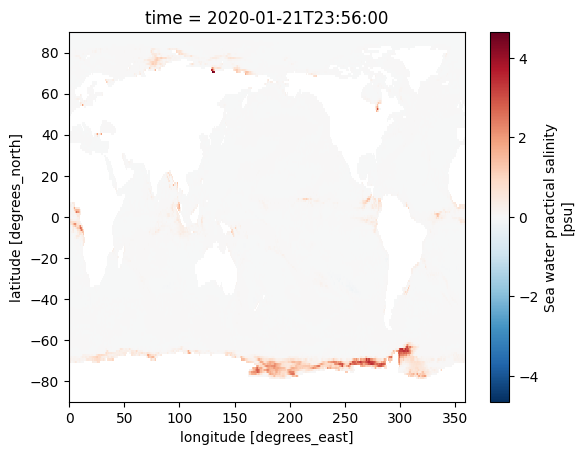

In [7]:
(vint['so'][1,0,:,:]-regridded['so'][1,0,:,:]).plot()

## IFS

Another example of what can be achieved with the vertical interpolation can be shown with IFS

In [8]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMU_atm3d", regrid="r100")
data = reader.retrieve()
data

2023-11-30 16:37:02 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-30 16:37:02 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right


<xarray.Dataset>
Dimensions:  (time: 1389, plev: 23, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2021-01-01
  * plev     (plev) float64 1e+05 9.75e+04 9.5e+04 ... 3e+03 1e+03 100.0
Dimensions without coordinates: value
Data variables: (12/15)
    cc       (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ciwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    clwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    crwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    cswc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    d        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ...       ...
    u        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    v        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    vo       (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    w        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    z        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ~        (time, plev, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

We just select one variable, and then we ask to perform the vertical interpolation. Please note that we will convert the unit asking a specific units for the vertical axis. We ask for a single specific vertical level, and we plot it after regridding. 

2023-11-30 16:37:07 :: Reader :: WARNING  -> Converting vert_coord units to interpolate from Pa to hPa


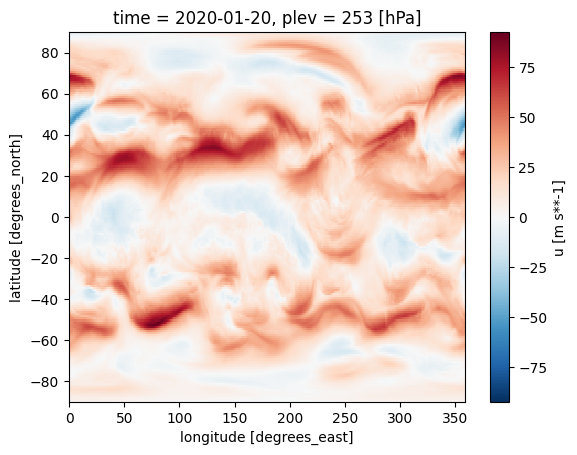

In [9]:
interp=reader.vertinterp(data['u'].isel(time=[0,1]), levels=253, vert_coord='plev', units='hPa')
final=reader.regrid(interp)
final[0,:,:].plot()